# MLProto Demo

This notebook demos a use case of the MLProto LSTM prototyping tool which we will use to demo different model structures. It is a notebook version of the stock.py example found in the examples module of the MLProto source code [here](https://github.com/CSLukeW/MLProto/blob/master/MLProto/Examples/stock.py). 

## Environment

In [1]:
# stock data garnered from alpha_vantage api
from alpha_vantage.timeseries import TimeSeries

# MLProto imports
from MLProto.MLProto import Proto as proto
from MLProto.MLProto import Data as helper

# other dependencies
import argparse
from matplotlib import pyplot
import pandas
import numpy
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Data Collection

The Alpha Vantage API offers a variety of options for pulling historical financial market data. We will be using daily adjusted stats going back 20 years or to the public debut of the company, whichever is closer to present day.

Below is the function we will use to pull data from Alpha Vantage.

In [2]:
def daily_adjusted(symbol, key, compact=True):
    """ Returns data frame of queried data
        args:
            symbol -- symbol of desired stock
            key -- user's API key
        compact -- True -> last 100 results
                   False -> all past results
    """

    # create time series
    ts = TimeSeries(key=key, output_format='pandas')

    # take last 100 or complete historical as needed
    if compact:
        data, _ = ts.get_daily_adjusted(symbol=symbol, outputsize='compact')
    else:
        data, _ = ts.get_daily_adjusted(symbol=symbol, outputsize='full')

    return data

The next code block stores and shows the full stock data for General Electric. We drop the last 3 features for the sake of simplicity.

1. open  2. high  3. low  4. close
date                                          
1999-11-01   133.63   134.38  129.25    129.38
1999-11-02   129.69   133.13  128.19    129.00
1999-11-03   132.88   132.94  130.00    131.38
1999-11-04   132.50   133.56  130.50    131.88
1999-11-05   133.19   134.81  133.19    133.75
...             ...      ...     ...       ...
2020-07-15     7.09     7.21    7.03      7.14
2020-07-16     7.06     7.18    6.99      7.05
2020-07-17     7.06     7.15    6.98      7.07
2020-07-20     7.01     7.06    6.86      6.87
2020-07-21     6.94     7.15    6.90      7.04

[5213 rows x 4 columns]



<Figure size 432x288 with 0 Axes>

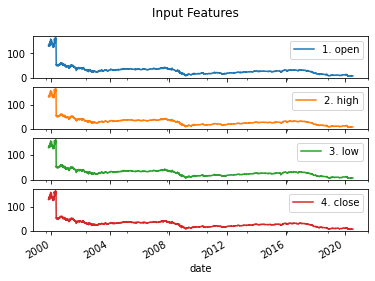

In [3]:
# get data from Alpha Vantage
apikey = open('./key.txt', 'r').read()
hist = daily_adjusted('GE', apikey, compact=False)

# Drop irrelevant values
hist = hist.drop(['5. adjusted close', '6. volume', '7. dividend amount', '8. split coefficient'], axis=1)

# Reverse the index order to ascending
hist = hist.reindex(index=hist.index[::-1])

# output
print(hist)
print()

pyplot.figure()
hist.plot(subplots=True)
pyplot.suptitle('Input Features')
pyplot.show()

## Model Creation, Training, and Evaluation

The Proto module takes care of model creation, training, and evaluation all with three simple function calls. The initialization function creates the model, and the other two operations have their own functions. 

A sample is illustrated below using the data collected above. We pass the identifier, data, and target column index only in this example, however the Proto constructor supports a variety of keyword arguments, such as "batch", "depth", and "loss" to fine-tune the model's general structure.

Constructing model...
Model Constructed!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM0 (LSTM)                 (None, 100)               42000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/100
66/66 [==============================] - 2s 31ms/step - loss: 1322.3636 - val_loss: 536.5012
Epoch 2/100
66/66 [==============================] - 2s 23ms/step - loss: 1178.0305 - val_loss: 437.2672
Epoch 3/100
66/66 [==============================] - 2s 23ms/step - loss: 1045.7650 - val_loss: 328.0428
Epoch 4/100
66/66 [==============================] - 2s 23ms/step - loss: 922.2322 - val_loss: 250.5930
Epoch 5/100
66/66 [============================

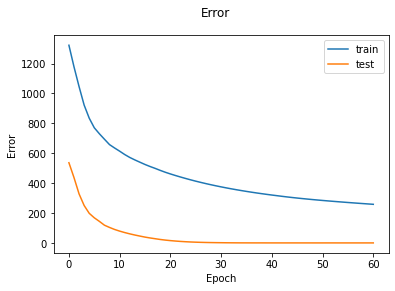



Evaluation:
20/20 [==============================] - 0s 7ms/step - loss: 0.3739


In [4]:
# create a model using the identifier, input dataframe, and target column index. All other kwargs are default.
model = proto.Proto('GE', hist, 3)
print()

# train for 100 epochs or until the validation loss does not improve for 5 straight epochs
model.train(100, True, False)

# plot losses
pyplot.figure()
pyplot.plot(model.history.history['loss'], label='train')
pyplot.plot(model.history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Error')
pyplot.legend()
pyplot.suptitle('Error')
pyplot.show()
print('\n')

# evaluate model using validation data
print('Evaluation:')
model.evaluate()

## Predictions

Using the newly-created model, we will now run predictions on the test data stored in the proto object.

Predicting:
31/31 [==============================] - 0s 5ms/step



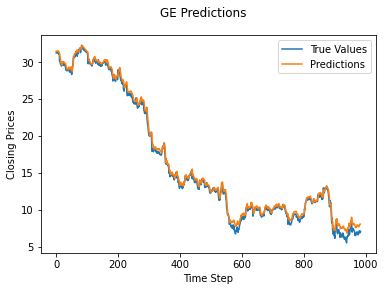

In [5]:
# populate predictions array
print('Predicting:')
predictions = model.predict_data(model.val_in)
print()

# pull out corresponding real values for comparison
standard_numpy = hist[int(hist.shape[0]*(.8))+60:]['4. close'].to_numpy()

# plot findings
pyplot.figure()
pyplot.plot(standard_numpy, label='True Values')
pyplot.plot(predictions[:, 0], label='Predictions')
pyplot.xlabel('Time Step')
pyplot.ylabel('Closing Prices')
pyplot.suptitle('GE Predictions')
pyplot.legend()
pyplot.show()